In [114]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import time
from numba import jit

## Rao-Blackwellization of the Metropolis-Hasting algorithm in the general case

In [115]:
f = stats.t(df=3)  # Target distribution
#sigma = 0.34  #Acceptance Rate 0.33
#sigma = 2.5   #Acceptance Rate 0.75
sigma = 0.34
g = lambda y,sigma: stats.cauchy(loc=y,scale=1/sigma)

#### Optimized version of the Metropolis-Hasting Algorithm :
This version used memory-preallocation and avoid recalculating the same densities. It is about 2 times faster than the previous one.

In [126]:
def metropolis_hastings(num_samples, sigma, target_density_start=True):
   
    random_uniforms = np.random.rand(num_samples+1)
    
    current_sample = f.rvs() if target_density_start else g(random_uniforms[0]).rvs()
    
    proposed_samples = np.zeros(num_samples+1)
    accepted_samples = np.zeros(num_samples+1)
    proposed_samples[0] = current_sample
    accepted_samples[0] = current_sample
    
    f_current = f.pdf(current_sample)
    g1 = g(current_sample,sigma)  # g(.|Z_n)
    
    for i in range(1,num_samples+1):
        
        proposal = g1.rvs()     
        g2 = g(proposal,sigma) #g(.|Y_n+1)
        f_proposed = f.pdf(proposal)
        
        acceptance_ratio = (f_proposed / g1.pdf(proposal)) / (f_current / g2.pdf(current_sample)) 
        #The minimum between 1 and the acceptance ratio is computationnaly useless 
        
        if random_uniforms[i] < acceptance_ratio:
                current_sample = proposal
                f_current = f_proposed
                g1 = g2
    
        proposed_samples[i] = proposal
        accepted_samples[i] = current_sample
    
    return np.array(accepted_samples), np.array(proposed_samples)

    
n=10000
start_time = time.time()
_,_ = metropolis_hastings(n,sigma)
end_time = time.time()
loop_time = (end_time - start_time) 
print(f"Time to compute : {loop_time}")

Time to compute : 5.220407009124756


#### Independent Metropolis-Hasting code for the next cell

In [120]:
@jit(nopython=True)
def loop(num_samples,current_sample,proposed_samples,random_uniforms,F,G):
  
    accepted_samples = np.empty(num_samples + 1)  # Preallocate memory
    accepted_samples[0] = current_sample
     
    current_f_pdf = F[0]
    current_g_pdf = G[0]

    for i in range(1, num_samples + 1):
        proposed_f_pdf = F[i]
        proposed_g_pdf = G[i]
        
        # Calculate the acceptance ratio
        acceptance_ratio = min(1, (proposed_f_pdf / proposed_g_pdf) / 
                                 (current_f_pdf / current_g_pdf))
        
        # Decide whether to accept the proposal
        if random_uniforms[i] < acceptance_ratio:
            current_sample = proposed_samples[i]
            current_f_pdf = proposed_f_pdf  
            current_g_pdf = proposed_g_pdf
        
        accepted_samples[i] = current_sample
    return accepted_samples, proposed_samples

def independent_metropolis_hastings(num_samples,f,g,target_density_start=True):
    current_sample = f.rvs() if target_density_start else g.rvs()
    proposed_samples = g.rvs(size=num_samples + 1)
    proposed_samples[0] = current_sample
    random_uniforms = np.random.rand(num_samples + 1)
    F = f.pdf(proposed_samples)
    G = g.pdf(proposed_samples)
    return loop(num_samples,current_sample,proposed_samples,random_uniforms,F,G)
    
n=10000
start_time = time.time()
_,_ = independent_metropolis_hastings(n,f,g(0,sigma))
end_time = time.time()
loop_time = (end_time - start_time) 
print(f"Time to compute : {loop_time}")


Time to compute : 0.09751558303833008


Metropolis Hastings samples generation progress: 100.00%

Independent Metropolis Hastings samples generation progress: 100.00%



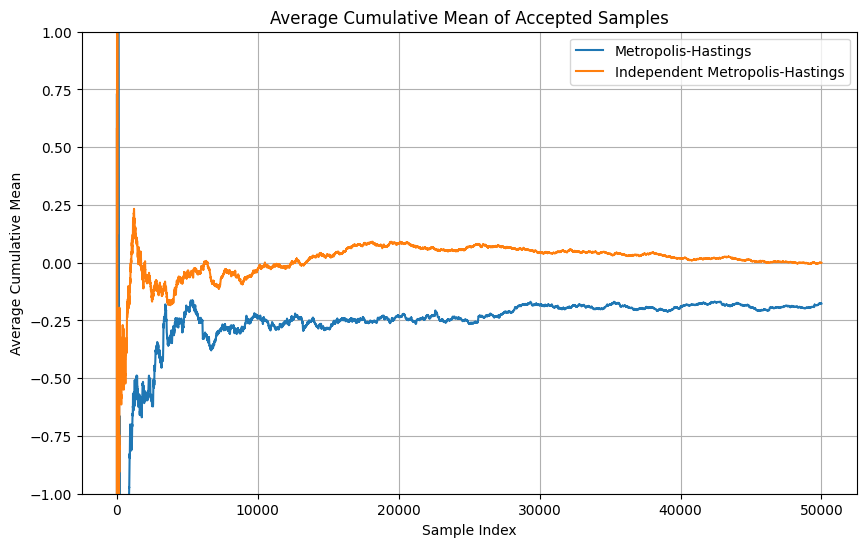

In [133]:
number_of_samples = 10
sample_size = 50000

# Initialize storage for accepted samples from both methods
accept_samples_mh = np.zeros(sample_size+1)
accept_samples_imh = np.zeros(sample_size+1)

# Simulate sampling using the regular Metropolis-Hastings method
for j in range(number_of_samples):
    temp1, _ = metropolis_hastings(sample_size, sigma) 
    accept_samples_mh+=np.array(temp1)
    print(f"Metropolis Hastings samples generation progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')
print("\n")

# Simulate sampling using the Independent Metropolis-Hastings method
for j in range(number_of_samples):
    g_ind = g(f.rvs(), sigma)
    temp1,_ = independent_metropolis_hastings(sample_size, f, g_ind) 
    accept_samples_imh+=np.array(temp1)
    print(f"Independent Metropolis Hastings samples generation progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')
print("\n")

# Calculate cumulative means
def calc_cumulative_means(samples):
    cum_means = [np.cumsum(sample) / np.arange(1, len(sample) + 1) for sample in samples]
    return np.array(cum_means)

cum_means_mh = np.cumsum(accept_samples_mh)/np.arange(1,sample_size+2)
cum_means_imh = np.cumsum(accept_samples_imh)/np.arange(1,sample_size+2)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(cum_means_mh, label='Metropolis-Hastings')
plt.plot(cum_means_imh, label='Independent Metropolis-Hastings')
plt.xlabel('Sample size')
plt.ylabel('Average Cumulative Mean')
plt.title('Cumulative Mean of Accepted Samples Averaged Over 10 runs')
plt.legend()
plt.ylim(-1,1)
plt.grid(True)
plt.show()


### Implementation of the Rao-Blackwellized, Importance-Sampling and Rao-Blackwellized Imp. Sampl. estimators :
This implementations takes advantage of numpy vectorization, memory pre-allocation (computing G,F,Rho in advance to avoid redundant calculations), and use JIT to maximize the computation speed. Since both RB and RB Importance Sampling estimator use the same intermediary value, I'm computing them in advance to be used by both estimators

In [7]:
def compute_G(Y,g,sigma):
    n = len(Y)
    G = np.zeros((n,n))
    for j in range(n):
        G[:, j] = g(Y[j],sigma).pdf(Y)
    return G

def compute_F(Y,f):
    return f.pdf(Y)
    
@jit(nopython=True)
def compute_rho(Y,F,G):
    n = len(Y)
    rho = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            rho[i,j]= np.minimum(1, (F[j]/G[j,i])  /  (F[i]/G[i,j]))
    return rho


@jit(nopython=True)
def compute_rho_hat_star(Y, rho, G):
    n = len(Y)-1
    rho_hat_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_hat_star[i, j] = rho[i,j]*G[j+1,j]
    return rho_hat_star

@jit(nopython=True)
def compute_rho_star(Y, rho, G):
    n = len(Y)-1
    rho_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_star[i, j] = (1-rho[i,j])*G[j+1,i]
    return rho_star

@jit(nopython=True)
def compute_zeta(Y, rho_star):
    n = len(Y)-1
    zeta = np.eye(n)
    for i in range(n-1):
        for j in range(i + 1, n):
            zeta[i, j] = zeta[i, j-1]*rho_star[i,j]
    return zeta

@jit(nopython=True)
def compute_deltas(Y, zeta, rho_hat_star,rho):
    n = len(Y)-1
    deltas = np.zeros(n+1)
    deltas[0] = 1
    for j in range(1,n):
        sum_term = 0
        for t in range(j):
            sum_term += deltas[t] * zeta[t, j - 1] * rho_hat_star[t, j]
        deltas[j] = sum_term
    for t in range(n):
        deltas[n]+=deltas[t]*zeta[t,n-1]*rho[t,n]
    return deltas

@jit(nopython=True)
def compute_omega(Y,rho_hat_star, rho_star):
    n = len(Y)
    omegas = np.zeros((n, n))
    for i in range(n):
        omegas[n-1,i]=1
    for i in range(n - 2, 0, -1):
        for j in range(i):
            omegas[i, j] = rho_hat_star[j,i] * omegas[i + 1, i] + rho_star[j, i] * omegas[i + 1, j]
    return omegas


@jit(nopython=True)
def compute_phi(i, Y, rho, zeta, deltas, omegas):
    n = len(Y)-1
    if i == n:
        return deltas[n]
    else:
        sum_term = 0
        for j in range(i, n):
            sum_term += zeta[i, j] * omegas[j+1,i]
        sum_term+= zeta[i, n - 1] * (1 - rho[i, n])
        return deltas[i] * sum_term

#Computing all the intermediary value at once to be used by both Rao-Blackwellized estimators
def compute_intermediary_value(Y,sigma):
    F = compute_F(Y,f)
    G = compute_G(Y,g,sigma)
    rho = compute_rho(Y,F,G)
    rho_hat_star = compute_rho_hat_star(Y, rho, G)
    rho_star = compute_rho_star(Y, rho, G)
    zeta = compute_zeta(Y, rho_star)
    deltas = compute_deltas(Y, zeta, rho_hat_star, rho)
    omegas = compute_omega(Y,rho_hat_star, rho_star)

    return [F,G,rho,rho_hat_star,rho_star,zeta,deltas,omegas]


def rao_blackwell_estimator(Y,intermediary):
    
    F = intermediary[0]
    G = intermediary[1]
    rho = intermediary[2]
    rho_hat_star = intermediary[3]
    rho_star = intermediary[4]
    zeta = intermediary[5]
    deltas = intermediary[6]
    omegas = intermediary[7]
    
    n = len(Y)-1
    den = 0
    for i in range(n):
        den+= deltas[i]*zeta[i,n-1]

    num = 0
    for i in range(n+1):
        phi_i = compute_phi(i, Y, rho, zeta, deltas, omegas)
        num += phi_i * Y[i]
    return (num/den)/(n+1)

def rao_blackwell_importance_sampling_estimator(Y,intermediary):
    
    F = intermediary[0]
    G = intermediary[1]
    rho = intermediary[2]
    rho_hat_star = intermediary[3]
    rho_star = intermediary[4]
    zeta = intermediary[5]
    deltas = intermediary[6]
    omegas = intermediary[7]
    
    temp = Y[0] + Y[1]*F[1]/G[1,0]

    n = len(Y)-1
    den = 0
    for i in range(n):
        den+= deltas[i]*zeta[i,n-1]

    num = 0
    for i in range(2,n+1):
        for j in range(0,i):
            num+= F[i]*deltas[j]*zeta[j,i-2]*(1-rho[j,i-1])*omegas[i,j]*Y[i]
    return (temp+(num/den))/(n+1)


def importance_sampling_estimator(accept,proposal,f,g,sigma):
    n = len(proposal)-1
    est = 0 
    for j in range(1,n+1):
        est+= (f.pdf(proposal[j])/g(accept[j-1],sigma).pdf(proposal[j]))*proposal[j]/(n+1)
    return est

In [8]:
#Parameters
number_of_samples = 500
sample_size = 50
sigma = 0.34

# Collect the samples
accept_samples, proposal_samples = [], []
for j in range(number_of_samples):
    temp1,temp2 = metropolis_hastings(sample_size,sigma)
    accept_samples.append(temp1)
    proposal_samples.append(temp2)
    print(f"Metropolis Hasting samples generation progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')
print("")


#Main computation
res_RB = []
res_MC = []
res_IS = []
res_IS_RB = []

for j,sample in enumerate(proposal_samples):
       
    # Classic MC estimator 
    res_MC.append(np.mean(accept_samples[j]))

    intermediary = compute_intermediary_value(sample,sigma)
    
    # Rao-Blackwellized MH estimator 
    res_RB.append(rao_blackwell_estimator(sample,intermediary))
    
    # Import. Sampl. estimator 
    res_IS.append(importance_sampling_estimator(accept_samples[j],sample,f,g,sigma))

    # Rao-Blackwellized IS estimator 
    res_IS_RB.append(rao_blackwell_importance_sampling_estimator(sample,intermediary))

    print(f"Estimators computation progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

print("\n")
true_mean = 0

# Display the means
print(f"Target mean: {true_mean}")
print(f"Classic MC empirical average mean: {np.mean(res_MC):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res_RB):.5f}")
print(f"Importance Sampling empirical average mean: {np.mean(res_IS):.5f}")
print(f"Rao-Blackwell Imp. Samp. average mean: {np.mean(res_IS_RB):.5f}")

# Compute and display the MSEs
classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
RB_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)

print(f"\nClassic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Importance Sampling MSE: {importance_sampling_mse:.5f}")
print(f"Rao-Blackwell Imp. Samp. MSE: {RB_importance_sampling_mse:.5f}")

# Compute MSE decrease percentages
mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100

mse_decrease_is = classic_mc_mse - importance_sampling_mse
percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100

mse_decrease_rb_is = classic_mc_mse - RB_importance_sampling_mse
percent_decrease_rb_is = (mse_decrease_rb_is / classic_mc_mse) * 100

print("")
print(f"Percentage decrease in MSE (Rao-Blackwell vs Classic MC): {percent_decrease_rb:.2f}%")
print(f"Percentage decrease in MSE (Importance Sampling vs Classic MC): {percent_decrease_is:.2f}%")
print(f"Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): {percent_decrease_rb_is:.2f}%")



Metropolis Hasting samples generation progress: 100.00%
Estimators computation progress: 100.00%

Target mean: 0
Classic MC empirical average mean: 0.02668
Rao-Blackwell empirical average mean: 0.02016
Importance Sampling empirical average mean: -0.00164
Rao-Blackwell Imp. Samp. average mean: 0.00437

Classic MC MSE: 0.36154
Rao-Blackwell MSE: 0.31930
Importance Sampling MSE: 0.04203
Rao-Blackwell Imp. Samp. MSE: 0.02292

Percentage decrease in MSE (Rao-Blackwell vs Classic MC): 11.68%
Percentage decrease in MSE (Importance Sampling vs Classic MC): 88.37%
Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): 93.66%


## Comparative Analysis of Estimation Techniques: Classic Monte Carlo, Rao-Blackwell Metropolis Hasting, Importance Sampling, and Rao Blackwell Imp. Sampl. :

In [10]:
samples_sizes = [3,5,10,25,50,100]
number_of_samples = 5000
sigmas = [0.34,2.5]

Matrix_res_33 = np.zeros((len(samples_sizes),8))
Matrix_res_75 = np.zeros((len(samples_sizes),8))

for c,sigma in enumerate(sigmas):
    Matrix_res = Matrix_res_33 if sigma==0.34 else Matrix_res_75
    for i,s in enumerate(samples_sizes) : 
        res_RB = []
        res_MC = []
        res_IS = []
        res_IS_RB = []
        
        for j in range (number_of_samples):
    
            accept,propos = metropolis_hastings(s,sigma)
            Y = propos
       
            # Classic MC estimator tau_7
            res_MC.append(np.mean(accept))
    
            intermediary = compute_intermediary_value(Y,sigma)
            # Rao-Blackwellized estimator tau_8
            res_RB.append(rao_blackwell_estimator(Y,intermediary))

            # Importance Sampling estimator tau_9
            res_IS.append(importance_sampling_estimator(accept,propos,f,g,sigma))
            
            # Rao-Blackwellized Import. Sampl. estimator tau_10
            res_IS_RB.append(rao_blackwell_importance_sampling_estimator(Y,intermediary))
            
            progress_message = f"{c+1}/{2} Progress: {i+1}/{len(samples_sizes)} : {100 * (j + 1) / number_of_samples:.2f}%"
            print(progress_message.ljust(50), end='\r')

        
        true_mean = 0
        Matrix_res[i,0]=np.mean(res_MC)
        Matrix_res[i,1]=np.mean(res_RB)
        Matrix_res[i,2]=np.mean(res_IS)
        Matrix_res[i,3]=np.mean(res_IS_RB)
        
    
        classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
        rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
        importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
        rb_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)
    
        Matrix_res[i,4]=classic_mc_mse
        
        
        # Compute MSE decrease percentages
        mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
        percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100
        
        mse_decrease_is = classic_mc_mse - importance_sampling_mse
        percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100

        mse_decrease_is_rb = classic_mc_mse - rb_importance_sampling_mse
        percent_decrease_is_rb = (mse_decrease_is_rb / classic_mc_mse) * 100
        
        Matrix_res[i,5]=percent_decrease_rb
        Matrix_res[i,6]=percent_decrease_is
        Matrix_res[i,7]=percent_decrease_is_rb

#### Estimation of the mean of the target distribution with acceptance rate 33% over 10000 runs:

In [12]:
results = [
    'MC Metrop.',
    'RB Metrop.',
    'Imp. sampl.',
    'RB import. sampl.',
    'MSE Metrop.',
    'MSE decrease RB over MC (%)',
    'MSE decrease IS over MC (%)',
    'MSE decrease RB-IS over MC (%)']

df_results = pd.DataFrame(Matrix_res_33, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
3,0.00382,0.00201,0.00007,0.00050,2.07408,8.79356,81.90763,78.60511
5,-0.05585,-0.04374,-0.00155,-0.00726,2.57708,7.03798,87.51917,88.99998
10,0.02188,0.02796,0.00208,0.00374,1.31413,9.28927,86.44040,90.52293
25,-0.00509,-0.00040,0.00396,0.00032,0.73466,10.37251,89.33114,93.70481
50,0.01140,0.00978,0.00014,0.00313,0.49758,6.97884,91.85004,95.63958
100,-0.00111,-0.00082,-0.00157,-0.00050,0.22210,9.70450,90.54650,94.92176


#### Estimation of the mean of the target distribution with acceptance rate 75% over 10000 runs:

In [14]:
results = [
    'MC Metrop.',
    'RB Metrop.',
    'Imp. sampl.',
    'RB import. sampl.',
    'MSE Metrop.',
    'MSE decrease RB over MC (%)',
    'MSE decrease IS over MC (%)',
    'MSE decrease RB-IS over MC (%)']

df_results = pd.DataFrame(Matrix_res_75, index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
3,-0.00281,0.00150,0.00874,0.00408,2.56416,1.97237,54.65498,72.10238
5,0.00948,0.00925,-0.00761,0.00322,2.38182,0.84204,65.82720,84.35141
10,-0.00229,0.00055,-0.00181,0.00640,2.87371,0.48354,83.45541,94.87181
25,0.00373,0.00312,-0.00394,0.00019,1.94012,0.25739,88.51987,97.67844
50,0.02640,0.02732,0.00398,0.00097,1.39244,0.16408,91.81609,98.50980
100,0.00073,0.00063,0.00333,0.00098,0.72483,0.14893,91.58109,98.63579


#### How many more sample do we have to generate using MH to achieve the same MSE as the Rao-Blackwell estimator with samples size = 100 ?

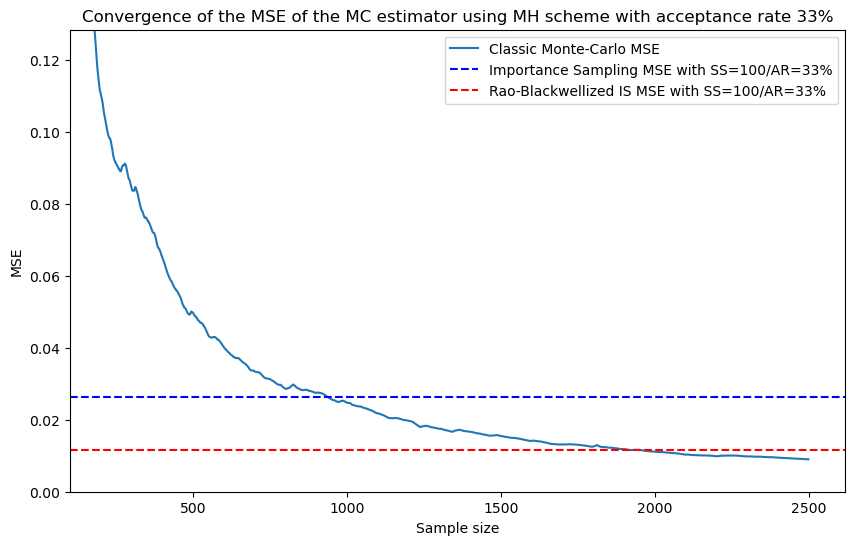

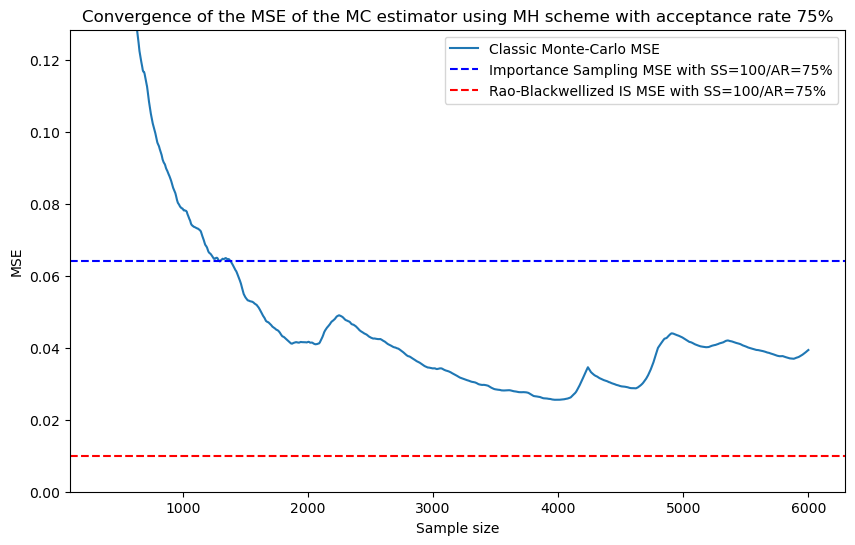

In [16]:
# Parameters
MSE_values_is = [0.02633, 0.06425]
MSE_values_is_rb = [0.01151, 0.01007]
true_mean = 0
number_of_samples = 500
sigmas = [0.34,2.5]
AR = ['33%','75%']

for k,sigma in enumerate(sigmas):
    
    tt = np.arange(100, 2500+k*3500, 1)
    mse_mh = np.zeros(len(tt))
    
    for j in range(number_of_samples):
        accept, _ = metropolis_hastings(tt[-1], sigma) 
        
        # For each t in tt, calculate MSE from the start of the chain up to t
        for i,t in enumerate(tt):
            subset_accept = accept[:t]
            MC_estimate = ((np.mean(subset_accept) - true_mean) ** 2)/number_of_samples
            mse_mh[i]+= MC_estimate
    
        # Progress indicator
        progress = 100 * (j + 1) / number_of_samples
        print(f"Progress: {progress:.2f}%".ljust(50), end='\r')
    
    
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(tt, mse_mh, label='Classic Monte-Carlo MSE')
    plt.axhline(y=MSE_values_is[k], color='b', linestyle='--', label=f'Importance Sampling MSE with SS=100/AR={AR[k]}')
    plt.axhline(y=MSE_values_is_rb[k], color='r', linestyle='--', label=f'Rao-Blackwellized IS MSE with SS=100/AR={AR[k]}')
    plt.legend()
    plt.ylim(0, 2 * MSE_values_is[1])
    plt.xlim(100)
    plt.xlabel('Sample size')
    plt.ylabel('MSE')
    plt.title(f"Convergence of the MSE of the MC estimator using MH scheme with acceptance rate {AR[k]}")
    plt.show()


#### Computation time comparison for the four estimators

In [18]:
# Parameters
size = [800,2500,1800,6000]
true_mean = 0  # True mean for MSE calculation
number_of_samples = 500  # Number of runs for the average computation time and MSE
sigmas = [0.34,2.5]
results = []

compteur = 1
# Classic Monte Carlo MSE and time computation 
for k,s in enumerate(size):
    
    sigma = 0.34 if (k==0 or k==1) else 2.5
    
    
    start_time = time.time()
    mse_classic_mc = 0
        
    for i in range(number_of_samples):
        accept, _ = metropolis_hastings(s,sigma)
        temp = np.mean(accept)
        mse_classic_mc += (temp - true_mean) ** 2  # Accumulate squared error
        print(f"{compteur}/{8} Classic MC Progress: {100 * (i + 1) / number_of_samples:.2f}%", end='\r')
    
    mse_classic_mc /= number_of_samples
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples  

    results.append({
        "Estimator": "Classic MC",
        "Size": s,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_classic_mc
    })
    compteur+=1

#Importance Sampling and Rao-BlackWell Imp. Sampl. MSE and times computation
for k,sigma in enumerate(sigmas):
    
    start_time = time.time()
    samples_proposal = []
    for _ in range(number_of_samples):
        accept, proposal = metropolis_hastings(100,sigma)
        samples_proposal.append(proposal)
    
    res = []
    for j, sample in enumerate(samples_proposal):
        intermediary = compute_intermediary_value(sample,sigma)
        res.append(rao_blackwell_importance_sampling_estimator(sample,intermediary))
        
        print(f"{compteur}/{8} RB Importance Sampling Progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "RB Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1
    
    start_time = time.time()
    samples_accept = []
    samples_proposal = []
    for _ in range(number_of_samples):
        accept, proposal = metropolis_hastings(100,sigma)
        samples_accept.append(accept)
        samples_proposal.append(proposal)
    
    res = []
    for j in range(number_of_samples):
    
        res.append(importance_sampling_estimator(samples_accept[j],samples_proposal[j],f,g,sigma))
    
        print(f"{compteur}/{8} Importance Sampling Progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1


print("Results :")
results_df = pd.DataFrame(results)
df_rate_33 = results_df[results_df["Sigma"] == 0.34].round(5)
df_rate_75 = results_df[results_df["Sigma"] == 2.5].round(5)

print("Results for Acceptance rate 33%")
print(df_rate_33)
print("\nResults for Acceptance rate 75%")
print(df_rate_75)
#Those value should be re-organized properly in the report 

Results :tance Sampling Progress: 100.00%00%
Results for Acceptance rate 33%
                Estimator  Size  Sigma  Time (s)      MSE
0              Classic MC   800   0.34   0.46243  0.02802
1              Classic MC  2500   0.34   1.46820  0.01190
4  RB Importance Sampling   100   0.34   0.09796  0.01083
5     Importance Sampling   100   0.34   0.10569  0.02195

Results for Acceptance rate 75%
                Estimator  Size  Sigma  Time (s)      MSE
2              Classic MC  1800    2.5   1.05753  0.04447
3              Classic MC  6000    2.5   3.50379  0.02033
6  RB Importance Sampling   100    2.5   0.09821  0.00978
7     Importance Sampling   100    2.5   0.10693  0.07269
